# Boostrap fit : drifters

In [1]:
import os
from glob import glob
import threading

import numpy as np
import dask.dataframe as dd
from dask import delayed
import pandas as pd
import xarray as xr

%matplotlib inline
from matplotlib import pyplot as plt
#import matplotlib.animation as anima

import crocosi.postp as pp
from crocosi.jet import set_relevant_time
import phdequinox.croco_drifter as cdr
import scipy.interpolate as interpolate
from sklearn.utils import resample

In [2]:
from dask.distributed import Client, LocalCluster
#cluster = LocalCluster()
from dask_jobqueue import PBSCluster
cluster = PBSCluster()
w = cluster.scale(jobs=8)

In [3]:
from dask.distributed import Client
#client = Client()  # set up local cluster on your laptop
client = Client(cluster) # with distributed cluster

In [4]:
client

Client Scheduler: tcp://10.148.1.1:37497 Dashboard: http://10.148.1.1:8787/status,Cluster Workers: 7 Cores: 7 Memory: 119.98 GB


In [5]:
root_path = '/home/datawork-lops-osi/equinox/jetn/old/'
#root_path = '/home1/datawork/slgentil/'#jet_cfg1_wp75_4km_1500a2000j_floats_lev50
run = 'jet_cfg1_wp75_4km_1500a2000j_itide/'

In [6]:
dr = cdr.drifter_dataframe(root_path+run,parquet=True,index='id',persist=False)
dr

         time      xgrid      ygrid  zgrid     depth       temp         u  \
id                                                                          
1   1514.4167  25.897255  174.72748   50.0  0.870458  24.579730 -0.000864   
1   1508.3056  26.356433  168.51951   50.0  0.763907  24.579722  0.059964   
1   1508.2986  26.348080  168.48829   50.0  0.764288  24.579721  0.054308   
1   1508.2917  26.340585  168.45690   50.0  0.764393  24.579721  0.048543   
1   1508.2847  26.333961  168.42548   50.0  0.764202  24.579721  0.042720   

           v      dudt          dvdt      pres           x          y  
id                                                                     
1   0.089855  0.000009 -9.453702e-06  9.414380  103.589020  698.90992  
1   0.203875  0.000010 -4.799399e-06  8.369084  105.425732  674.07804  
1   0.207708  0.000010 -3.143696e-06  8.372827  105.392320  673.95316  
1   0.209148  0.000010 -1.401524e-06  8.373855  105.362340  673.82760  
1   0.209600  0.000010  3.03

In [7]:
# Wrapping function to apply the correlation to each drifter
def wrap_correlate(DS,columns,T,dt,L,binsize,detrend=True):
#df_chunked = dr.df.groupby(['id']).apply(chunk_processing, 10., .5)
    df_chunked = DS.groupby(DS.index).apply(cdr.time_window_processing,
                                            cdr.correlate, columns, T, int(T/dt/2),L, detrend=detrend,dt=dt
                                           ).persist()
                                         #   meta=('x', 'f8'))
    # the dataframe partitions has a multi-index: id and window central time (unknow name for now)
    # we first transform the index corresponding to time into a regular column.
    df_chunked = (
                  df_chunked.map_partitions(
                      lambda df: df.reset_index(level=[1]).rename(columns={'level_1': 'time'})
                                           )
                  )
    # bin along y and sum
    y_bins = np.arange(0,2800,binsize)
    y_idx = pd.IntervalIndex.from_breaks(y_bins)
    df_chunked['y_cut'] = df_chunked['y'].map_partitions(pd.cut, bins=y_bins)
    return df_chunked

In [8]:
# inputs: time window and step
T = 40 # days
dt = 10./60./24. # days, hack required because dt fluctuates by a bit !!
binsize = 50 # binsize over which we will average the correlation function
L = 1024 # size of the domain in the x driection (periodicity)

In [9]:
# Autocorrelation of u
df_chunked = wrap_correlate(dr.df,['u','u'],T,dt,L,binsize,detrend=False)
df_chunked

/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: `meta` is not specified, inferred from partial data. Please provide `meta` if the result is unexpected.
  Before: .apply(func)
  After:  .apply(func, meta={'x': 'f8', 'y': 'f8'}) for dataframe result
  or:     .apply(func, meta=('x', 'f8'))            for series result
  """


Dask DataFrame Structure:
                  time        x        y       id      0.0 0.006944444444444444 0.013888888888888888 0.020833333333333332 0.027777777777777776 0.034722222222222224 0.041666666666666664 0.048611111111111105 0.05555555555555555   0.0625 0.06944444444444445 0.07638888888888888 0.08333333333333333 0.09027777777777778 0.09722222222222221 0.10416666666666666 0.1111111111111111 0.11805555555555555    0.125 0.13194444444444445 0.1388888888888889 0.14583333333333331 0.15277777777777776 0.1597222222222222 0.16666666666666666 0.1736111111111111 0.18055555555555555   0.1875 0.19444444444444442 0.20138888888888887 0.20833333333333331 0.21527777777777776 0.2222222222222222 0.22916666666666666 0.2361111111111111 0.24305555555555555     0.25 0.2569444444444444 0.2638888888888889 0.2708333333333333 0.2777777777777778 0.2847222222222222 0.29166666666666663 0.2986111111111111 0.3055555555555555   0.3125 0.3194444444444444 0.3263888888888889 0.3333333333333333 0.34027777777777773 0.3472222222222222 0.35416666666666663 0.3611111111111111 0.3680555555555555    0.375 0.3819444444444444 0.38888888888888884 0.3958333333333333 0.40277777777777773 0.4097222222222222 0.41666666666666663 0.4236111111111111 0.4305555555555555   0.4375 0.4444444444444444 0.45138888888888884 0.4583333333333333 0.46527777777777773 0.4722222222222222 0.47916666666666663 0.4861111111111111 0.4930555555555555      0.5 0.5069444444444444 0.5138888888888888 0.5208333333333333 0.5277777777777778 0.5347222222222222 0.5416666666666666 0.548611111111111 0.5555555555555556   0.5625 0.5694444444444444 0.5763888888888888 0.5833333333333333 0.5902777777777778 0.5972222222222222 0.6041666666666666 0.611111111111111 0.6180555555555555    0.625 0.6319444444444444 0.6388888888888888 0.6458333333333333 0.6527777777777778 0.6597222222222222 0.6666666666666666 0.673611111111111 0.6805555555555555   0.6875 0.6944444444444444 0.7013888888888888 0.7083333333333333 0.7152777777777778 0.7222222222222222 0.7291666666666666 0.736111111111111 0.7430555555555555     0.75 0.7569444444444444 0.7638888888888888 0.7708333333333333 0.7777777777777777 0.7847222222222222 0.7916666666666666 0.798611111111111 0.8055555555555555   0.8125 0.8194444444444444 0.8263888888888888 0.8333333333333333 0.8402777777777777 0.8472222222222222 0.8541666666666666 0.861111111111111 0.8680555555555555    0.875 0.8819444444444444 0.8888888888888888 0.8958333333333333 0.9027777777777777 0.9097222222222222 0.9166666666666666 0.923611111111111 0.9305555555555555   0.9375 0.9444444444444444 0.9513888888888888 0.9583333333333333 0.9652777777777777 0.9722222222222222 0.9791666666666666 0.986111111111111 0.9930555555555555      1.0 1.0069444444444444 1.0138888888888888 1.0208333333333333 1.0277777777777777 1.034722222222222 1.0416666666666665 1.0486111111111112 1.0555555555555556   1.0625 1.0694444444444444 1.0763888888888888 1.0833333333333333 1.0902777777777777 1.097222222222222 1.1041666666666665 1.1111111111111112 1.1180555555555556    1.125 1.1319444444444444 1.1388888888888888 1.1458333333333333 1.1527777777777777 1.159722222222222 1.1666666666666665 1.173611111111111 1.1805555555555556   1.1875 1.1944444444444444 1.2013888888888888 1.2083333333333333 1.2152777777777777 1.222222222222222 1.2291666666666665 1.236111111111111 1.2430555555555556     1.25 1.2569444444444444 1.2638888888888888 1.2708333333333333 1.2777777777777777 1.284722222222222 1.2916666666666665 1.298611111111111 1.3055555555555556   1.3125 1.3194444444444444 1.3263888888888888 1.3333333333333333 1.3402777777777777 1.347222222222222 1.3541666666666665 1.361111111111111 1.3680555555555556    1.375 1.3819444444444444 1.3888888888888888 1.3958333333333333 1.4027777777777777 1.409722222222222 1.4166666666666665 1.423611111111111 1.4305555555555556   1.4375 1.4444444444444444 1.4513888888888888 1.4583333333333333 1.4652777777777777 1.472222222222222 1.4791666666666665 1.486111111111111 1.4930555555555556      1.5 1.5069444444444444 1.5138888888

In [10]:
df_chunked['y_cut'] = df_chunked.y_cut.map(lambda v : v.mid)
df_chunked['y_cut'] = df_chunked['y_cut'].astype('float64')
df_chunked = df_chunked.drop(columns=['id']).reset_index()

In [11]:
df_chunked = df_chunked.persist()

### Selection of one bin for tests

In [41]:
test = df_chunked.groupby('y_cut').get_group(1550.).compute()

In [42]:
test

,id,time,x,y,0.0,0.006944444444444444,0.013888888888888888,0.020833333333333332,0.027777777777777776,0.034722222222222224,...,19.9375,19.944444444444443,19.95138888888889,19.958333333333332,19.965277777777775,19.97222222222222,19.979166666666664,19.98611111111111,19.993055555555554,y_cut
2,742,1560.0069,500.277442,1534.925795,0.851583,0.851206,0.850496,0.849441,0.848045,0.846313,...,0.053293,0.053588,0.053906,0.054240,0.054586,0.054940,0.055298,0.055655,0.056008,1550.0
3,742,1580.0069,851.340447,1565.185682,0.806511,0.806263,0.805633,0.804628,0.803252,0.801513,...,0.000360,0.000435,0.000514,0.000596,0.000680,0.000764,0.000847,0.000928,0.001005,1550.0
7,742,1660.0069,739.672261,1558.793929,0.469662,0.469447,0.468879,0.467967,0.466718,0.465144,...,0.052039,0.051283,0.050539,0.049809,0.049097,0.048407,0.047742,0.047106,0.046501,1550.0
8,742,1680.0069,663.078899,1573.373099,0.665635,0.665389,0.664766,0.663772,0.662417,0.660715,...,0.242119,0.242096,0.242035,0.241937,0.241802,0.241631,0.241424,0.241182,0.240907,1550.0
26,758,1580.0069,938.176309,1586.512124,0.508873,0.508670,0.508129,0.507260,0.506070,0.504572,...,0.059532,0.059686,0.059828,0.059960,0.060079,0.060185,0.060279,0.060359,0.060426,1550.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57,414,1740.0069,970.664485,1538.748681,0.896632,0.896347,0.895617,0.894452,0.892866,0.890868,...,0.258752,0.258182,0.257641,0.257131,0.256657,0.256219,0.255820,0.255462,0.255146,1550.0
98,795,1640.0069,62.943057,1532.088429,0.129863,0.129587,0.128866,0.127707,0.126120,0.124122,...,0.010825,0.011204,0.011577,0.011941,0.012293,0.012628,0.012944,0.013236,0.013503,1550.0
134,1433,1740.0069,140.409480,1580.216282,0.116520,0.116294,0.115655,0.114606,0.113156,0.111317,...,0.020744,0.020586,0.020397,0.020179,0.019932,0.019658,0.019359,0.019036,0.018693,1550.0
226,4029,1740.0069,315.334099,1515.013075,1.444338,1.443780,1.442876,1.441632,1.440059,1.438168,...,0.378250,0.378699,0.379189,0.379718,0.380286,0.380891,0.381532,0.382207,0.382912,1550.0


### Resampling and averaging 


In [33]:
resample_bin = test.drop(columns=['y_cut','id','time','x','y'])

In [34]:
B = 5
ds = pd.concat([resample_bin.sample(frac=1,replace=True,axis='index').mean('index')
                .rename('sample_%s'%(i+1)) for i in range(B)],axis='columns')
ds = pd.concat([resample_bin.mean('index').rename('Original'),ds],axis='columns')
#ds = ds.assign_coords({'sample':range(B+1)}).rename({'index':'lags'})

In [37]:
np.isnan(ds['Original']).any()

True

In [20]:
ds.index = ds.index.astype('float64')

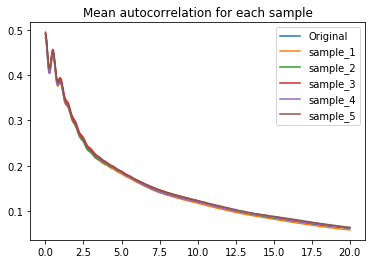

In [21]:
ds.plot.line(title='Mean autocorrelation for each sample')

### Fit over each sample

In [12]:
from inspect import signature
from scipy import signal
import scipy
def param_fit(x,myfunc,bounds,X = 'normalized'):
    """Find the best fit using the function myfunc. The parameters are computed fitting the data using myfunc 
    to the average over all segments for each draws.
    Parameters
    ----------
        x : DataArray
            Correaltionfunction to fit
        myfunc: func
                Function used for the fit
        var : str
              variable to fit
        X : str
            If X='Normalized', the fit will be made on normalized autocorrelation function
        name: str, optional
    
    Returns
    ----------
    out : Dataset
          Dataset containing the parameters fitted using myfunc for all draws.
    """
    sig = signature(myfunc)
    
    if X=='normalized':
        _x = x/x.loc[0] 
    else :
        _x = x
 #   pa = np.full((1,len(sig.parameters)-1),np.nan)
    pa,co = scipy.optimize.curve_fit(myfunc,_x.index,_x,bounds=bounds)
    #    err[i,:] = np.abs(pa[i,:]-true_val)/true_val
    
    out = pd.DataFrame(pa,index=[V for V in sig.parameters.keys()][1:],columns=[x.name])
#    out.attrs = {'time window ' : DT,'number of segments' : nT}
    return out

In [13]:
om = 2 # tidal frequency (M2)
# Fast contribution
def Ctilde(t,Tt):
    return np.exp(-t/Tt)*np.cos(2*np.pi*om*t)#*np.cos(2*np.pi*nu*t)
#Slow contribution
def Cbar(t,Tb,Om):
    return np.exp(-t/Tb)*np.cos(2*np.pi*Om*t)
#Total formula
def C(t,Tt,Xtilde,Tb,Xbar,Omega):
    return Xbar*Cbar(t,Tb,Omega)+Xtilde*Ctilde(t,Tt)

In [14]:
# Parameters fit
myfunc = C # model to use in the fit
sig = signature(myfunc)
bounds = (0,np.inf) # bounds
Nparams = len([V for V in sig.parameters.keys()][1:]) # Number of parameters to fit

In [25]:
fitted = pd.concat([param_fit(ds[sample],myfunc,bounds,X='') for sample in ds.columns],axis='columns')

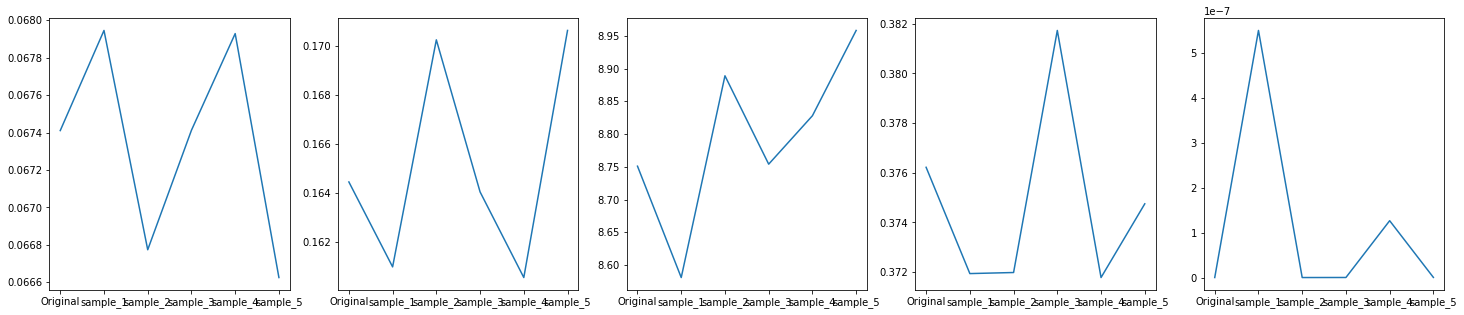

In [26]:
fig, axs = plt.subplots(1,Nparams,figsize=(5*Nparams,5))
for param, ax in zip(fitted.index,axs):
    fitted.loc[param].plot(ax=ax) 

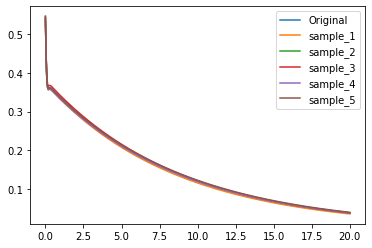

In [27]:
for V in fitted.columns:
    plt.plot(ds.index.values,C(ds.index.values,*[p for p in fitted[V]]),label=V)
plt.legend()

### Bootstrap

In [28]:
bias = fitted.sub(fitted['Original'],axis='index')

In [41]:
alpha = .05
q = bias.loc[:,'sample_1':].quantile([alpha,1-alpha], axis='columns')
deltau = q.iloc[0]
deltal = q.iloc[1]
ci = [fitted['Original'].sub(deltal,axis='index'),fitted['Original'].sub(deltau,axis='index')]

In [33]:
[(V,V+'_lower',V+'_upper') for V in fitted.index]

[('Tt', 'Tt_lower', 'Tt_upper'),
 ('Xtilde', 'Xtilde_lower', 'Xtilde_upper'),
 ('Tb', 'Tb_lower', 'Tb_upper'),
 ('Xbar', 'Xbar_lower', 'Xbar_upper'),
 ('Omega', 'Omega_lower', 'Omega_upper')]

In [57]:
out = pd.DataFrame(np.array([ci[0].values]),columns=[V+'_lower' for V in fitted.index.values],index=test.y_cut.unique())
#ci[0].set_index.values = [V+'_lower' for V in fitted.index.values]

In [58]:
for V in fitted.index.values:
    out[V+'_upper'] = ci[1][V]
    out[V] = fitted['Original'][V]

In [60]:
out

,Tt_lower,Xtilde_lower,Tb_lower,Xbar_lower,Omega_lower,Tt_upper,Tt,Xtilde_upper,Xtilde,Tb_upper,Tb,Xbar_upper,Xbar,Omega_upper,Omega
1525.0,0.066879,0.158352,8.557448,0.372108,-4.661758e-07,0.068166,0.067411,0.168268,0.164456,8.886248,8.750865,0.38063,0.376222,2.245596e-12,1.310431e-11


In [150]:
from IPython.display import Latex
names = [r'$\bar{T}$',r'$\bar{X}$',r'$\Omega$']
print('Confidence intervals : ')
Latex("$\:\:$".join('%s$\in$[%s;%s]'%
                         (names[i],ci[0].loc[fitted.index[i]],ci[1].loc[fitted.index[i]]) for i in range(len(names))))



Confidence intervals : 


<IPython.core.display.Latex object>

### Expanding to all the dataset : 

In [15]:
def wrap_bootstrap(df_chunked,B,myfunc,bounds,alpha=0.05):
    y = df_chunked.y_cut
    resample_bin = df_chunked.drop(columns=['y_cut','id','time','x','y'])
    _ds = pd.concat([resample_bin.sample(frac=1,replace=True,axis='index').mean('index')
                    .rename('sample_%s'%(i+1)) for i in range(B)],axis='columns')
    _ds = pd.concat([resample_bin.mean('index').rename('Original'),_ds],axis='columns')
    _ds.index = _ds.index.astype('float64')
    if np.isnan(_ds['Original']).any():
        print('Failed')
    else:
        fitted = pd.concat([param_fit(_ds[sample],myfunc,bounds,X='') for sample in _ds.columns],axis='columns')
        deltastar = fitted.sub(fitted['Original'],axis='index')
        q = deltastar.loc[:,'sample_1':].quantile([alpha,1-alpha], axis='columns')
        deltau = q.iloc[0]
        deltal = q.iloc[1]
        ci = [fitted['Original'].sub(deltal,axis='index'),fitted['Original'].sub(deltau,axis='index')]
        out = pd.DataFrame(np.array([ci[0].values]),columns=[V+'_lower' for V in fitted.index.values],index=y.unique())
        for V in fitted.index.values:
            out[V+'_upper'] = ci[1][V]
            out[V] = fitted['Original'][V]
        return out

In [16]:
tst = df_chunked.groupby(['y_cut']).apply(wrap_bootstrap,1,C,(0,np.inf)).persist()
tst

/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: `meta` is not specified, inferred from partial data. Please provide `meta` if the result is unexpected.
  Before: .apply(func)
  After:  .apply(func, meta={'x': 'f8', 'y': 'f8'}) for dataframe result
  or:     .apply(func, meta=('x', 'f8'))            for series result
  """Entry point for launching an IPython kernel.


,Tt_lower,Xtilde_lower,Tb_lower,Xbar_lower,Omega_lower,Tt_upper,Tt,Xtilde_upper,Xtilde,Tb_upper,Tb,Xbar_upper,Xbar,Omega_upper,Omega
npartitions=753,,,,,,,,,,,,,,,
,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


In [49]:
res = tst.compute()

In [50]:
res = res.reset_index().drop(columns='level_1')

In [51]:
res = res.set_index('y_cut').sort_index().to_xarray()

In [52]:
res

<xarray.Dataset>
Dimensions:       (y_cut: 22)
Coordinates:
  * y_cut         (y_cut) float64 550.0 650.0 750.0 ... 2.55e+03 2.65e+03
Data variables:
    Tt_lower      (y_cut) float64 3.161 3.055 3.186 3.054 ... 1.997 2.571 2.438
    Xtilde_lower  (y_cut) float64 0.008301 0.008627 0.008897 ... 0.03264 0.01935
    Tb_lower      (y_cut) float64 16.61 20.92 23.69 ... 16.69 19.84 -5.381e-06
    Xbar_lower    (y_cut) float64 0.00517 0.00587 ... 0.02053 -4.518e-06
    Omega_lower   (y_cut) float64 0.01835 0.015 0.01387 ... 0.008405 2.627
    Tt_upper      (y_cut) float64 3.161 3.055 3.186 3.054 ... 1.997 2.571 2.438
    Tt            (y_cut) float64 3.218 3.048 3.178 3.037 ... 1.991 2.556 2.509
    Xtilde_upper  (y_cut) float64 0.008301 0.008627 0.008897 ... 0.03264 0.01935
    Xtilde        (y_cut) float64 0.008243 0.008611 0.008918 ... 0.03313 0.01974
    Tb_upper      (y_cut) float64 16.61 20.92 23.69 ... 16.69 19.84 -5.381e-06
    Tb            (y_cut) float64 16.9 20.99 23.78 ... 16.52 19.64 5.502e-06
    Xbar_upper    (y_cut) float64 0.00517 0.00587 ... 0.02053 -4.518e-06
    Xbar          (y_cut) float64 0.005175 0.005946 ... 0.02011 1.377e-11
    Omega_upper   (y_cut) float64 0.01835 0.015 0.01387 ... 0.008405 2.627
    Omega         (y_cut) float64 0.0182 0.01503 0.01392 ... 0.008478 2.189

In [42]:
params = [V for V in sig.parameters.keys()][1:]

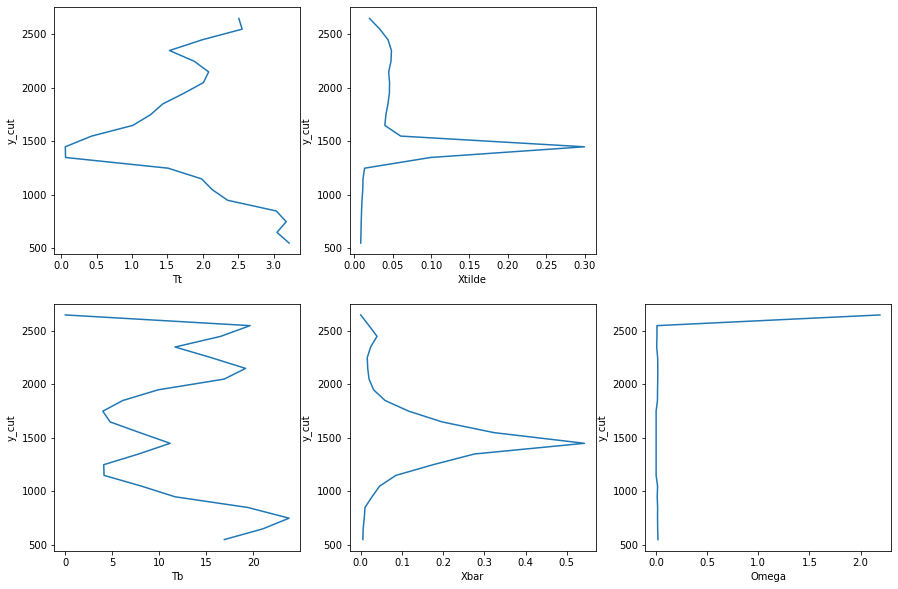

In [55]:
fig,axs = plt.subplots(2,3,figsize=(15,10))
for p,ax in zip(params[:2],axs[0,:]):
    res[p].plot(ax=ax,y='y_cut')
for p,ax in zip(params[2:],axs[1,:]):
    res[p].plot(ax=ax,y='y_cut')
fig.delaxes(axs[0,2])

In [56]:
cluster.close()

distributed.client - ERROR - Failed to reconnect to scheduler after 10.00 seconds, closing client
_GatheringFuture exception was never retrieved
future: <_GatheringFuture finished exception=CancelledError()>
concurrent.futures._base.CancelledError
